In [1]:
import sys
sys.path.insert(0, "../code")

import h5py as h5
import itertools
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy import (coordinates as coord, units as u)
from astropy.coordinates.matrix_utilities import (matrix_product, rotation_matrix)
from tqdm import tqdm
from scipy import (optimize as op)
from astropy import constants

from matplotlib.colors import LogNorm
from matplotlib import cm
from mpl_utils import mpl_style
from matplotlib.collections import LineCollection

import twobody


plt.style.use(mpl_style)

%matplotlib inline


np.random.seed(0)

In [2]:
def approximate_ruwe(t, P, m1, m2, distance, f1=None, f2=None, t0=None, 
                     i=0*u.deg, **kwargs):
    """
    Approximate the on-sky astrometric excess noise for a binary system with the
    given system parameters at a certain distance.

    This approximating function ignores the following effects:

    (1) The distortions that arise due to sky projections.
    (2) Inclination effects.
    (3) Omega effects.

    In part it also assumes:

    (1) The times were observed pseudo-randomly.
    (2) The orbit is fully sampled.

    :param t:
        The times that the system was observed.

    :param P:
        The period of the binary system.

    :param m1:
        The mass of the primary star.

    :param m2:
        The mass of the secondary system.

    :param distance:
        The distance from the observer to the center of mass of the binary
        system.

    :param f1: [optional]
        The flux of the primary star. If `None` is given then this is assumed to
        be $m_1^{3.5}$.

    :param f2: [optional]
        The flux of the secondary. If `None` is given then this is assumed to be
        $m_2^{3.5}$.

    :returns:
        A two-part tuple containing the root-mean-squared deviations in on-sky
        position (in units of milliarcseconds), and a dictionary containing meta
        information about the binary system.
    """

    if f1 is None:
        f1 = m1.to(u.solMass).value**3.5
    if f2 is None:
        f2 = m2.to(u.solMass).value**3.5

    if t0 is None:
        t0 = Time('J2015.5')

    m_total = m1 + m2
    w = np.array([f1, f2])/(f1 + f2)
    a = twobody.P_m_to_a(P, m_total).to(u.AU).value

    a1 = m2 * a / m_total
    a2 = m1 * a / m_total

    w1, w2 = (w[0], w[1])

    # TODO: replace this with integral!
    dt = (t - t0).to(u.day)
    phi = (2 * np.pi * dt / P).value
    N = phi.size

    dx = a1 * w1 * np.cos(phi) + a2 * w2 * np.cos(phi + np.pi)
    dy = a1 * w1 * np.sin(phi) + a2 * w2 * np.sin(phi + np.pi)

    planar_rms_in_au = np.sqrt(np.sum((dx - np.mean(dx))**2 + (dy - np.mean(dy))**2)/N).value

    # Need some corrections for when the period is longer than the observing timespan, and the
    # inclination angle is non-zero.

    # For this it really depends on what t0/Omega is: if you see half the orbit in one phase or
    # another...
    # TODO: this requires a thinko.
    

    """
    Approximate given some inclination angle.
    At zero inclination, assume circle on sky such that:
    
        rms = sqrt(ds^2 + ds^2) = sqrt(2ds^2)

    and 
        
        ds = np.sqrt(0.5 * rms^2)

    Now when inclined (even at 90) we still get ds + contribution:

        rms_new = sqrt(ds^2 + (cos(i) * ds)^2)
    """

    ds = np.sqrt(0.5 * planar_rms_in_au**2)
    rms_in_au = np.sqrt(ds**2 + (np.cos(i) * ds)**2)
    rms_in_mas = (rms_in_au * u.au / distance).to(u.mas, equivalencies=u.dimensionless_angles())

    # Intrinsic error on position in one direction is.
    # These are the final values. The individual epochs are probably about a 10th of this.
    intrinsic_ra_error = 0.029 # mas
    intrinsic_dec_error = 0.026 # mas

    intrinsic_ra_error /= 10
    intrinsic_dec_error /= 10

    chi2 = N * rms_in_mas.to(u.mas).value**2 / np.sqrt(intrinsic_ra_error**2 + intrinsic_dec_error**2)

    approx_ruwe = np.sqrt(chi2/(N - 2))

    meta = dict(weights=w,
                a=a,
                a1=a1,
                a2=a2,
                w1=w1,
                w2=w2,
                phi=phi,
                dx=dx,
                dy=dy,
                rms_in_au=rms_in_au)

    return (approx_ruwe, meta)

In [3]:
np.random.seed(0)

N = 10000 # simulations per distance trial
O = 200 # number of observations per source

# Let's assume a hot jupiter around a Sun-like star.
M_1 = 1 * u.solMass
M_2 = 1 * u.jupiterMass

# let's assume hot jupiter periods are 3-9 days.
P = np.random.uniform(3, 9, N) * u.day
cos_i = np.random.uniform(0, 1, N)
i = np.arccos(cos_i) * u.rad

f_1, f_2 = (1, 0)


# Assume that we observe each system at a uniformly random time.
# From https://www.cosmos.esa.int/web/gaia/dr2
obs_start, obs_end = (Time('2014-07-25T10:30'), Time('2016-05-23T11:35')) 
t = obs_start + np.random.uniform(0, 1, O) * (obs_end - obs_start)

# Let us assume that anything with RUWE > 1.5 will be a binary.
ruwe_binarity_threshold = 1.5

In [4]:
fiducial_distance = 1 * u.pc
fiducial_ruwe = np.zeros(N, dtype=float)
for j in tqdm(range(N)):
    fiducial_ruwe[j], meta = approximate_ruwe(t, P[j], M_1, M_2, fiducial_distance, f1=f_1, f2=f_2, i=i[j])


100%|██████████| 10000/10000 [00:25<00:00, 390.79it/s]


In [7]:
# Now calculate for many distances.
distances = np.linspace(1, 1000, 10000) * u.pc
D = distances.size

# Just store a detection completeness at each distance.
completeness = np.zeros(D, dtype=float)
for j, distance in tqdm(enumerate(distances)):
    ruwe = fiducial_ruwe * (fiducial_distance/distance)
    # Calculate the efficiency of detection at this distance
    completeness[j] = np.sum(ruwe >= ruwe_binarity_threshold)/N
    

10000it [00:01, 9302.41it/s]


[]

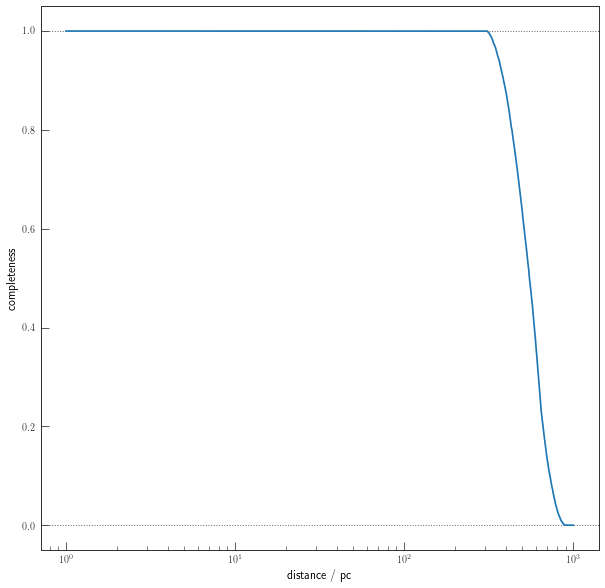

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(distances, completeness, ms=0)
ax.axhline(0, c="#666666", linestyle=":", lw=1, zorder=-1, ms=0)
ax.axhline(1, c="#666666", linestyle=":", lw=1, zorder=-1, ms=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"{distance / pc}")
ax.set_ylabel(r"{completeness}")
ax.semilogx()

In [18]:
# seems like bullshit -- get the list of known hot jupiters within 1 kpc
# https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=planets

from astropy.table import Table
#!mv /Users/arc/Downloads/planets_2019.07.18_16.51.51.csv .
# clean out first 360 rows
t = Table.read("planets_2019.07.18_16.51.51.csv")


In [19]:
t

rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_ttvflag,pl_kepflag,pl_k2flag,pl_nnotes,ra_str,ra,dec_str,dec,st_dist,st_disterr1,st_disterr2,st_distlim,gaia_dist,gaia_disterr1,gaia_disterr2,gaia_distlim,st_optmag,st_optmagerr,st_optmaglim,st_optband,gaia_gmag,gaia_gmagerr,gaia_gmaglim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_mass,st_masserr1,st_masserr2,st_masslim,st_rad,st_raderr1,st_raderr2,st_radlim,rowupdate,pl_tranflag,pl_rvflag,pl_imgflag,pl_astflag,pl_omflag,pl_cbflag,pl_angsep,pl_angseperr1,pl_angseperr2,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orblper,pl_orblpererr1,pl_orblpererr2,pl_orblperlim,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_massj,pl_massjerr1,pl_massjerr2,pl_massjlim,pl_msinij,pl_msinijerr1,pl_msinijerr2,pl_msinijlim,pl_masse,pl_masseerr1,pl_masseerr2,pl_masselim,pl_msinie,pl_msinieerr1,pl_msinieerr2,pl_msinielim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_rads,pl_radserr1,pl_radserr2,pl_radslim,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,pl_tsystemref,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,pl_ratdorlim,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratrorlim,pl_def_reflink,pl_disc,pl_disc_reflink,pl_locale,pl_facility,pl_telescope,pl_instrument,pl_status,pl_mnum,pl_st_npar,pl_st_nref,pl_pelink,pl_edelink,pl_publ_date,hd_name,hip_name,st_rah,st_glon,st_glat,st_elon,st_elat,st_plx,st_plxerr1,st_plxerr2,st_plxlim,gaia_plx,gaia_plxerr1,gaia_plxerr2,gaia_plxlim,st_pmra,st_pmraerr,st_pmralim,st_pmdec,st_pmdecerr,st_pmdeclim,st_pm,st_pmerr,st_pmlim,gaia_pmra,gaia_pmraerr,gaia_pmralim,gaia_pmdec,gaia_pmdecerr,gaia_pmdeclim,gaia_pm,gaia_pmerr,gaia_pmlim,st_radv,st_radverr1,st_radverr2,st_radvlim,st_sp,st_spstr,st_sperr,st_splim,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_lum,st_lumerr1,st_lumerr2,st_lumlim,st_dens,st_denserr1,st_denserr2,st_denslim,st_metfe,st_metfeerr1,st_metfeerr2,st_metfelim,st_metratio,st_age,st_ageerr1,st_ageerr2,st_agelim,st_vsini,st_vsinierr1,st_vsinierr2,st_vsinilim,st_acts,st_actserr,st_actslim,st_actr,st_actrerr,st_actrlim,st_actlx,st_actlxerr,st_actlxlim,swasp_id,st_nts,st_nplc,st_nglc,st_nrvc,st_naxa,st_nimg,st_nspec,st_uj,st_ujerr,st_ujlim,st_vj,st_vjerr,st_vjlim,st_bj,st_bjerr,st_bjlim,st_rc,st_rcerr,st_rclim,st_ic,st_icerr,st_iclim,st_j,st_jerr,st_jlim,st_h,st_herr,st_hlim,st_k,st_kerr,st_klim,st_wise1,st_wise1err,st_wise1lim,st_wise2,st_wise2err,st_wise2lim,st_wise3,st_wise3err,st_wise3lim,st_wise4,st_wise4err,st_wise4lim,st_irac1,st_irac1err,st_irac1lim,st_irac2,st_irac2err,st_irac2lim,st_irac3,st_irac3err,st_irac3lim,st_irac4,st_irac4err,st_irac4lim,st_mips1,st_mips1err,st_mips1lim,st_mips2,st_mips2err,st_mips2lim,st_mips3,st_mips3err,st_mips3lim,st_iras1,st_iras1err,st_iras1lim,st_iras2,st_iras2err,st_iras2lim,st_iras3,st_iras3err,st_iras3lim,st_iras4,st_iras4err,st_iras4lim,st_photn,st_umbj,st_umbjerr,st_umbjlim,st_bmvj,st_bmvjerr,st_bmvjlim,st_vjmic,st_vjmicerr,st_vjmiclim,st_vjmrc,st_vjmrcerr,st_vjmrclim,st_jmh2,st_jmh2err,st_jmh2lim,st_hmk2,st_hmk2err,st_hmk2lim,st_jmk2,st_jmk2err,st_jmk2lim,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn
int64,str27,str1,str29,str29,int64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,f

In [42]:
# select hot jupiters:
#PER[day] < 10 AND MSINI[mjupiter] > 0.5

# COLUMN pl_orbper:      Orbital Period [days]
# COLUMN pl_orbpererr1:  Orbital Period Upper Unc. [days]
# COLUMN pl_orbpererr2:  Orbital Period Lower Unc. [days]
# COLUMN pl_orbperlim:   Orbital Period Limit Flag
# COLUMN pl_msinij:      Planet M*sin(i) [Jupiter mass]
# COLUMN pl_msinijerr1:  Planet M*sin(i) Upper Unc. [Jupiter mass]
# COLUMN pl_msinijerr2:  Planet M*sin(i) Lower Unc. [Jupiter mass]
# COLUMN pl_msinijlim:   Planet M*sin(i) Limit Flag

is_hot_jupiter = (t["pl_orbper"] < 10) \
               & (t["pl_msinij"] > 0.5) \
               & (~t["pl_orbper"].mask) \
               & (~t["pl_msinij"].mask)

#t[is_hot_jupiter]["pl_orbper", "pl_orbpererr1", "pl_orbpererr2", "pl_orbperlim", "pl_msinij", "pl_msinijerr1", "pl_msinijerr2", "pl_msinijlim"]
#t[~t["pl_orbper"].mask]["pl_orbper"]
#t[is_hot_jupiter]["pl_orbper"]
print(np.sum(is_hot_jupiter))

45


In [43]:
t[is_hot_jupiter]["pl_orbper", "pl_orbpererr1", "pl_orbpererr2", "pl_orbperlim", "pl_msinij", "pl_msinijerr1", "pl_msinijerr2", "pl_msinijlim"]


pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_msinij,pl_msinijerr1,pl_msinijerr2,pl_msinijlim
float64,float64,float64,int64,float64,float64,float64,int64
3.48777,0.00011,-0.00011,0,0.59,0.07,-0.07,0
6.180235,1.4e-05,-1.4e-05,0,3.0,1.1,-1.2,0
4.46529976,5.5e-07,-5.5e-07,0,0.524,0.019,-0.019,0
5.6335158,3.6e-06,-3.6e-06,0,8.62,0.17,-0.17,0
3.65281514,7.6e-07,-7.5e-07,0,0.569,0.023,-0.022,0
2.1500082,1.3e-07,-1.3e-07,0,0.68,0.11,-0.1,0
3.92281072,1.02e-06,-1.02e-06,0,0.748,0.063,-0.063,0
6.4947,0.00019,-0.00019,0,0.96,0.023,-0.023,0
4.5557,0.0001,-0.0001,0,0.62,0.025,-0.025,0


In [44]:
t[is_hot_jupiter]

rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_ttvflag,pl_kepflag,pl_k2flag,pl_nnotes,ra_str,ra,dec_str,dec,st_dist,st_disterr1,st_disterr2,st_distlim,gaia_dist,gaia_disterr1,gaia_disterr2,gaia_distlim,st_optmag,st_optmagerr,st_optmaglim,st_optband,gaia_gmag,gaia_gmagerr,gaia_gmaglim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_mass,st_masserr1,st_masserr2,st_masslim,st_rad,st_raderr1,st_raderr2,st_radlim,rowupdate,pl_tranflag,pl_rvflag,pl_imgflag,pl_astflag,pl_omflag,pl_cbflag,pl_angsep,pl_angseperr1,pl_angseperr2,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orblper,pl_orblpererr1,pl_orblpererr2,pl_orblperlim,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_massj,pl_massjerr1,pl_massjerr2,pl_massjlim,pl_msinij,pl_msinijerr1,pl_msinijerr2,pl_msinijlim,pl_masse,pl_masseerr1,pl_masseerr2,pl_masselim,pl_msinie,pl_msinieerr1,pl_msinieerr2,pl_msinielim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_rads,pl_radserr1,pl_radserr2,pl_radslim,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,pl_tsystemref,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,pl_ratdorlim,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratrorlim,pl_def_reflink,pl_disc,pl_disc_reflink,pl_locale,pl_facility,pl_telescope,pl_instrument,pl_status,pl_mnum,pl_st_npar,pl_st_nref,pl_pelink,pl_edelink,pl_publ_date,hd_name,hip_name,st_rah,st_glon,st_glat,st_elon,st_elat,st_plx,st_plxerr1,st_plxerr2,st_plxlim,gaia_plx,gaia_plxerr1,gaia_plxerr2,gaia_plxlim,st_pmra,st_pmraerr,st_pmralim,st_pmdec,st_pmdecerr,st_pmdeclim,st_pm,st_pmerr,st_pmlim,gaia_pmra,gaia_pmraerr,gaia_pmralim,gaia_pmdec,gaia_pmdecerr,gaia_pmdeclim,gaia_pm,gaia_pmerr,gaia_pmlim,st_radv,st_radverr1,st_radverr2,st_radvlim,st_sp,st_spstr,st_sperr,st_splim,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_lum,st_lumerr1,st_lumerr2,st_lumlim,st_dens,st_denserr1,st_denserr2,st_denslim,st_metfe,st_metfeerr1,st_metfeerr2,st_metfelim,st_metratio,st_age,st_ageerr1,st_ageerr2,st_agelim,st_vsini,st_vsinierr1,st_vsinierr2,st_vsinilim,st_acts,st_actserr,st_actslim,st_actr,st_actrerr,st_actrlim,st_actlx,st_actlxerr,st_actlxlim,swasp_id,st_nts,st_nplc,st_nglc,st_nrvc,st_naxa,st_nimg,st_nspec,st_uj,st_ujerr,st_ujlim,st_vj,st_vjerr,st_vjlim,st_bj,st_bjerr,st_bjlim,st_rc,st_rcerr,st_rclim,st_ic,st_icerr,st_iclim,st_j,st_jerr,st_jlim,st_h,st_herr,st_hlim,st_k,st_kerr,st_klim,st_wise1,st_wise1err,st_wise1lim,st_wise2,st_wise2err,st_wise2lim,st_wise3,st_wise3err,st_wise3lim,st_wise4,st_wise4err,st_wise4lim,st_irac1,st_irac1err,st_irac1lim,st_irac2,st_irac2err,st_irac2lim,st_irac3,st_irac3err,st_irac3lim,st_irac4,st_irac4err,st_irac4lim,st_mips1,st_mips1err,st_mips1lim,st_mips2,st_mips2err,st_mips2lim,st_mips3,st_mips3err,st_mips3lim,st_iras1,st_iras1err,st_iras1lim,st_iras2,st_iras2err,st_iras2lim,st_iras3,st_iras3err,st_iras3lim,st_iras4,st_iras4err,st_iras4lim,st_photn,st_umbj,st_umbjerr,st_umbjlim,st_bmvj,st_bmvjerr,st_bmvjlim,st_vjmic,st_vjmicerr,st_vjmiclim,st_vjmrc,st_vjmrcerr,st_vjmrclim,st_jmh2,st_jmh2err,st_jmh2lim,st_hmk2,st_hmk2err,st_hmk2lim,st_jmk2,st_jmk2err,st_jmk2lim,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn
int64,str27,str1,str29,str29,int64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,f

Max distance: 0.68 kpc


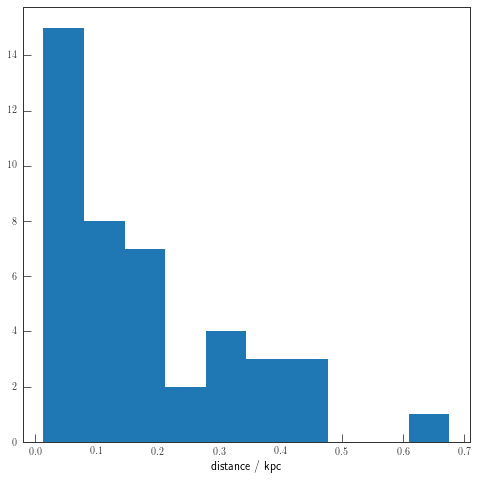

In [61]:
# Let's assume the Gaia cross-match they did is correct.

ok = is_hot_jupiter & (~t["gaia_plx"].mask)
hj_hosts = t[ok]

hj_plx = hj_hosts["gaia_plx"]

hj_dist = 1.0/hj_plx
print(f"Max distance: {np.max(hj_dist):.2f} kpc")

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(hj_dist)
ax.set_xlabel(r"{distance / kpc}")

In [59]:
!grep COLUMN planets_2019.07.18_16.51.51.csv.original | grep gaia

# COLUMN gaia_dist:      Gaia Distance [pc]
# COLUMN gaia_disterr1:  Gaia Distance Upper Unc. [pc]
# COLUMN gaia_disterr2:  Gaia Distance Lower Unc. [pc]
# COLUMN gaia_distlim:   Gaia Distance Limit Flag
# COLUMN gaia_gmag:      G-band (Gaia) [mag]
# COLUMN gaia_gmagerr:   G-band (Gaia) Unc. [mag]
# COLUMN gaia_gmaglim:   G-band (Gaia) Limit Flag
# COLUMN gaia_plx:       Gaia Parallax [mas]
# COLUMN gaia_plxerr1:   Gaia Parallax Upper Unc. [mas]
# COLUMN gaia_plxerr2:   Gaia Parallax Lower Unc. [mas]
# COLUMN gaia_plxlim:    Gaia Parallax Limit Flag
# COLUMN gaia_pmra:      Gaia Proper Motion (RA) [mas/yr]
# COLUMN gaia_pmraerr:   Gaia Proper Motion (RA) Unc. [mas/yr]
# COLUMN gaia_pmralim:   Gaia Proper Motion (RA) Limit Flag
# COLUMN gaia_pmdec:     Gaia Proper Motion (Dec) [mas/yr]
# COLUMN gaia_pmdecerr:  Gaia Proper Motion (Dec) Unc. [mas/yr]
# COLUMN gaia_pmdeclim:  Gaia Proper Motion (Dec) Limit Flag
# COLUMN gaia_pm:        Gaia Total Proper Motion [mas/yr]
# COLUMN gaia_pmerr:

In [63]:
# How can they not have given a Gaia source ID?!
# Need to do the cross-match ourselves.
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord

from tqdm import tqdm

In [76]:
gaia_xmatch = []

cone_radius = 5 * u.arcsecond
coords = SkyCoord(ra=hj_hosts["ra"] * u.deg, dec=hj_hosts["dec"] * u.deg)
matched = np.zeros(len(hj_hosts), dtype=bool)

for i, coord in tqdm(enumerate(coords), total=len(hj_hosts)):
    result = Gaia.cone_search(coord, radius=cone_radius)
    result = result.get_data()

    if len(result) > 0:
        #assert len(result) == 1
        gaia_xmatch.append(result[0]) # take closest source
        matched[i] = True



0it [00:00, ?it/s]WARNING: W35: None:5:0: W35: 'value' attribute required for INFO elements [astropy.io.votable.tree]

1it [00:00,  1.04it/s]
2it [00:01,  1.10it/s]
3it [00:02,  1.15it/s]
4it [00:03,  1.16it/s]
5it [00:04,  1.11it/s]
6it [00:05,  1.14it/s]
7it [00:06,  1.14it/s]
8it [00:06,  1.19it/s]
43it [00:37,  1.27it/s]


In [77]:
hj_hosts = hj_hosts[matched]
from astropy.table import vstack
gaia_xmatch = vstack(gaia_xmatch)

In [78]:
gaia_xmatch

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
float64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
0.000871366040815,1635721458409799680,Gaia DR2 3758629479636689536,3758629479636689536,736939382,2015.5,164.619124324,0.0467369931711,-10.7704226556,0.0311403870835,11.8187427116,0.0490731678225,240.839,-184.836146429,0.0845291454953,-8.37407482109,0.0578523131793,0.071826,-0.438518,0.0196025,0.348189,-0.1576,0.282575,-0.125741,0.064949,-0.199534,0.0904859,122,122,121,1,4.91168,207.066,0.0,0.0,31,True,250.515,1.58706247613,0.00991258820572,0.0703602,14,9,0.051716,0,21,False,162,2184845.48998,1221.25488544,1789.02,9.83981,18,1071762.76202,2443.31694876,438.651,10.2761,17,1555102.68801,2650.19110327,586.789,9.28252,1.20231,0,0.993619,0.436327,0.557292,26.9203057797,0.284335362393,4,5500.0,4.5,0.5,NOT_AVAILABLE,263.284664178,43.2379313407,170.134418762,-15.9679245159,100001,5335.5,5283.25,5393.0,0.2485,0.059,0.373,0.125,0.0305,0.1878,200111,0.939081,0.919163,0.957747,0.643875,0.640165,0.647584,http://geadata.esac.esa.int/data-server/datalink/links?ID=3758629479636689536,--
7.40806337445e-05,1635721458409799680,Gaia DR2 3393939026234131584,3393939026234131584,568533301,2015.5,78.9198196875,0.104701341114,16.2786991317,0.0622110168856,2.66391362448,0.130013757831,20.4895,2.71745450649,0.112019446791,-12.9828429862,0.0944101598742,-0.407527,0.805713,0.050

In [79]:
# calculate the RUWE for the HJ hosts. they all shoudl be >~1.5
#group.create_dataset("j_ast",
#                     data=np.sqrt(group["astrometric_chi2_al"][()]/(group["astrometric_n_good_obs_al"][()] - 5)))

gaia_xmatch["ruwe"] = np.sqrt(gaia_xmatch["astrometric_chi2_al"]/(gaia_xmatch["astrometric_n_good_obs_al"] - 5))

(array([ 1.,  5.,  4.,  4.,  7.,  2.,  1.,  0.,  2.,  1.]),
 array([ 1.07610751,  1.1763542 ,  1.2766009 ,  1.37684759,  1.47709429,
         1.57734098,  1.67758768,  1.77783437,  1.87808107,  1.97832776,
         2.07857445]),
 <a list of 10 Patch objects>)

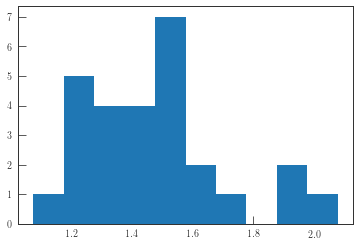

In [114]:
dist = 1.0 /gaia_xmatch["parallax"]
close = dist < 0.2

fig, ax = plt.subplots()
ax.hist(gaia_xmatch["ruwe"][close])

In [81]:
# I guess we assumed the host star masses,... and a period distribution..., and 0.5 jupiter masses..

In [105]:
!grep COLUMN planets_2019.07.18_16.51.51.csv.original | grep incl

# COLUMN pl_orbincl:     Inclination [deg]
# COLUMN pl_orbinclerr1: Inclination Upper Unc. [deg]
# COLUMN pl_orbinclerr2: Inclination Lower Unc. [deg]
# COLUMN pl_orbincllim:  Inclination Limit Flag


(array([ 1.,  0.,  3.,  3.,  8.,  8.,  6.,  5.,  4.,  3.]),
 array([ 0.42 ,  0.562,  0.704,  0.846,  0.988,  1.13 ,  1.272,  1.414,
         1.556,  1.698,  1.84 ]),
 <a list of 10 Patch objects>)

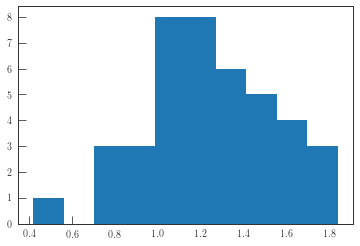

In [84]:
fig, ax = plt.subplots()
ax.hist(hj_hosts["st_mass"])

(array([ 2.,  8.,  8.,  5.,  7.,  1.,  7.,  1.,  1.,  1.]),
 array([ 0.9689951 ,  1.81982059,  2.67064608,  3.52147157,  4.37229706,
         5.22312255,  6.07394804,  6.92477353,  7.77559902,  8.62642451,
         9.47725   ]),
 <a list of 10 Patch objects>)

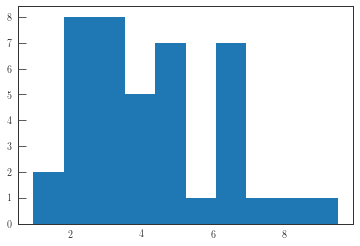

In [85]:
fig, ax = plt.subplots()
ax.hist(hj_hosts["pl_orbper"])

(array([ 12.,   9.,   8.,   0.,   2.,   0.,   2.,   1.,   1.,   0.,   3.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([  0.5       ,   0.82758621,   1.15517241,   1.48275862,
          1.81034483,   2.13793103,   2.46551724,   2.79310345,
          3.12068966,   3.44827586,   3.77586207,   4.10344828,
          4.43103448,   4.75862069,   5.0862069 ,   5.4137931 ,
          5.74137931,   6.06896552,   6.39655172,   6.72413793,
          7.05172414,   7.37931034,   7.70689655,   8.03448276,
          8.36206897,   8.68965517,   9.01724138,   9.34482759,
          9.67241379,  10.        ]),
 <a list of 29 Patch objects>)

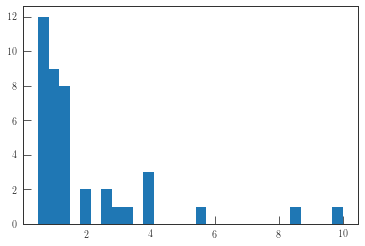

In [89]:
fig, ax = plt.subplots()
ax.hist(hj_hosts["pl_msinij"], bins=np.linspace(0.5, 10, 30))

In [109]:
# If we restrict to those that are definitely >1 jupiter mass
bigger = hj_hosts["pl_msinij"] >= 1


In [92]:
print(np.sum(bigger), bigger.size)

23 41


(array([ 14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.]),
 array([  0.   ,   8.898,  17.796,  26.694,  35.592,  44.49 ,  53.388,
         62.286,  71.184,  80.082,  88.98 ]),
 <a list of 10 Patch objects>)

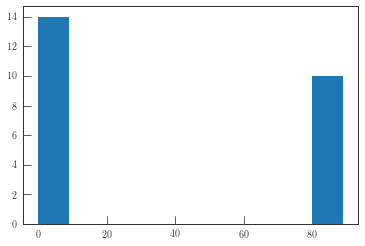

In [112]:
undetected = gaia_xmatch["ruwe"] < 1.5
fig, ax = plt.subplots()
ax.hist(hj_hosts["pl_orbincl"][undetected])

In [113]:
# I guess the ones we don't detect could be because of our assumption that it is just one planet perturbing it?
# Shoudl probably just work out what P, q, and i is possible given some RUWE, source magnitude and distance